In [1]:
import numpy as np
import pandas as pd
from datetime import datetime, timedelta
from typing import Dict, List, Tuple, Optional
import warnings
import talib as ta
from sklearn.linear_model import Ridge
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
import os

def _ensure_datetime(series: pd.Series) -> pd.Series:
    # 若已是datetime类型，直接返回
    if pd.api.types.is_datetime64_any_dtype(series):
        return series
    
    # 安全转换为数值类型（非数值转为NaN，避免astype直接报错）
    s = pd.to_numeric(series, errors='coerce')
    
    # 检查是否存在无法转换的非数值
    if s.isna().any():
        warnings.warn("序列中包含无法转换为数值的元素，已自动转为NaT")
    
    # 避免空序列导致的判断错误
    if s.empty:
        return pd.Series([], dtype='datetime64[ns]')
    
    # 基于2025年前后的合理时间戳范围设置阈值（单位：对应单位的数量）
    # 参考：2025年的时间戳约为 1.7e9秒 ≈ 1.7e12毫秒 ≈ 1.7e15微秒 ≈ 1.7e18纳秒
    ns_threshold = 1e17  # 纳秒级阈值（约317年，覆盖合理时间范围）
    us_threshold = 1e14  # 微秒级阈值（约317年）
    ms_threshold = 1e11  # 毫秒级阈值（约317年）
    s_abs = s.abs()  # 用绝对值判断量级，保留原始符号用于转换（支持负时间戳）
    
    # 按any()逻辑判断单位（只要有一个元素满足阈值就用对应单位）
    if (s_abs > ns_threshold).any():
        return pd.to_datetime(s, unit='ns', errors='coerce')
    elif (s_abs > us_threshold).any():
        return pd.to_datetime(s, unit='us', errors='coerce')
    elif (s_abs > ms_threshold).any():
        return pd.to_datetime(s, unit='ms', errors='coerce')
    else:
        return pd.to_datetime(s, unit='s', errors='coerce')

def generate_dollar_bars(trades_df, target_hour=1):
    """生成近似目标小时级的Dollar Bar"""
    # 计算小时级平均成交额作为阈值
    hourly_volume = trades_df.resample(f'{target_hour}H', on='trade_time')['dollar_amount'].sum()
    dollar_threshold = hourly_volume.mean()  # 阈值=目标小时级平均成交额
    
    # 生成Bar
    trades_df['cum_dollar'] = trades_df['dollar_amount'].cumsum()
    trades_df['bar_id'] = (trades_df['cum_dollar'] // dollar_threshold).astype(int)
    
    # 过滤不完整的最后一个Bar
    last_valid_id = trades_df['bar_id'].max() - 1
    trades_df = trades_df[trades_df['bar_id'] <= last_valid_id]
    
    # 提取每个Bar的时间区间和基础统计量
    bar_info = trades_df.groupby('bar_id').agg(
        start_time=('trade_time', 'min'),
        end_time=('trade_time', 'max'),
        total_dollar=('dollar_amount', 'sum'),
        price_open=('price', 'first'),
        price_close=('price', 'last'),
        price_high=('price', 'max'),
        price_low=('price', 'min'),
        trade_count=('price', 'count')
    ).reset_index()
    
    # 计算Bar的未来收益（预测目标：下一个Bar的涨跌幅）
    bar_info['future_return'] = (bar_info['price_close'].shift(-1) - bar_info['price_close']) / bar_info['price_close'] * 100
    
    return trades_df, bar_info, dollar_threshold

def build_dollar_bars(
    trades: pd.DataFrame,
    dollar_threshold: float,
) -> pd.DataFrame:
    """
    生成dollar bars，确保bar_id连续递增。
    
    改进点：
    1. 重构bar_id计算逻辑，通过跟踪累积成交额确保连续
    2. 避免因单笔大额交易导致的bar_id跳跃
    3. 仅过滤最后一个不完整的bar（若存在）
    """
    trades['time'] = _ensure_datetime(trades['time'])
    trades = trades.sort_values('time').reset_index(drop=True)
    df = trades.copy()
    # 处理时间列和排序
    # df['time'] = _ensure_datetime(df['time'])
    # df = df.sort_values('time').reset_index(drop=True)
    
    # 计算成交额（quote_qty）
    if 'quote_qty' not in df.columns or df['quote_qty'].isna().all():
        df['quote_qty'] = df['price'] * df['qty']
    
    # 标记交易方向
    df['trade_sign'] = np.where(df['is_buyer_maker'], -1, 1)
    df['buy_qty'] = df['qty'].where(df['trade_sign'] > 0, 0.0)
    df['sell_qty'] = df['qty'].where(df['trade_sign'] < 0, 0.0)
    
    # 核心改进：逐笔计算bar_id，确保连续递增
    cumulative = 0.0  # 累积成交额
    bar_id = 0        # 当前bar_id
    bar_ids = []      # 存储每个交易的bar_id
    cnt_list = []
    bar_trade_counts={}

    for qty in df['quote_qty']:
        cumulative += qty
        bar_trade_counts[bar_id] = bar_trade_counts.get(bar_id, 0) + 1
        # 当累积成交额达到阈值时，当前交易仍属于当前bar_id，随后bar_id递增并重置累积
        if cumulative >= dollar_threshold:
            bar_ids.append(bar_id)
            # 重置累积（保留超额部分，用于下一个bar的计算）
            cumulative -= dollar_threshold
            bar_id += 1
        else:
            bar_ids.append(bar_id)
    
    df['bar_id'] = bar_ids
    df['trades'] = df['bar_id'].map(bar_trade_counts)  # 关键修复：通过map对齐
    # 分组聚合
    agg = {
        'time': ['first', 'last'],
        'price': ['first', 'max', 'min', 'last'],
        'qty': 'sum',
        'quote_qty': 'sum',
        'buy_qty': 'sum',
        'sell_qty': 'sum',
        'trades': 'first' 
    }
    g = df.groupby('bar_id', sort=True).agg(agg)
    
    # 展平列名
    g.columns = [
        'start_time', 'end_time',
        'open', 'high', 'low', 'close',
        'volume', 'dollar_value',
        'buy_volume', 'sell_volume',
        'trades'
    ]
    
    # 仅过滤最后一个可能不完整的bar（若其成交额不足阈值）
    if not g.empty and g.iloc[-1]['dollar_value'] < dollar_threshold:
        g = g.iloc[:-1]
    
    # 重置bar_id为连续整数（避免因过滤最后一个bar导致的断档）
    g = g.reset_index(drop=True)
    g['bar_id'] = g.index
    
    return g
 


def _add_bar_lags_and_rollings(
    Xb: pd.DataFrame,
    add_lags: int = 2,
    rolling_windows: Optional[List[int]] = None,
    rolling_stats: Optional[List[str]] = None,
) -> pd.DataFrame:
    X = Xb.copy().sort_index()

    feature_cols = list(X.columns)

    # lags
    for k in range(1, add_lags + 1):
        for col in feature_cols:
            X[f'{col}_lag{k}'] = X[col].shift(k)

    # rollings
    if rolling_windows:
        stats = rolling_stats or ['mean', 'std', 'sum']
        for w in rolling_windows:
            roll = X[feature_cols].rolling(window=w, min_periods=w)
            for stat in stats:
                if stat == 'mean':
                    tmp = roll.mean()
                elif stat == 'std':
                    tmp = roll.std()
                elif stat == 'sum':
                    tmp = roll.sum()
                elif stat == 'min':
                    tmp = roll.min()
                elif stat == 'max':
                    tmp = roll.max()
                else:
                    continue
                tmp.columns = [f'{col}_roll{w}_{stat}' for col in X[feature_cols].columns]
                X = X.join(tmp)

    return X


 


def _time_splits_purged(
    idx: pd.DatetimeIndex,
    n_splits: int = 5,
    embargo: str = '0H',
) -> List[Tuple[pd.DatetimeIndex, pd.DatetimeIndex]]:
    """
    生成时间连续的折，返回 (train_index, test_index) 对列表。
    训练集对测试集边界施加 Embargo，避免信息泄露。
    """
    times = pd.Series(index=idx.unique().sort_values(), data=np.arange(len(idx.unique())))
    n = len(times)
    if n_splits < 2 or n < n_splits:
        raise ValueError('样本过少，无法进行时间序列CV')

    fold_sizes = [n // n_splits] * n_splits
    for i in range(n % n_splits):
        fold_sizes[i] += 1

    # 计算各折在时间索引上的切片范围
    boundaries = []
    start = 0
    for sz in fold_sizes:
        end = start + sz
        boundaries.append((start, end))
        start = end

    embargo_td = pd.Timedelta(embargo)
    out: List[Tuple[pd.DatetimeIndex, pd.DatetimeIndex]] = []
    for (s, e) in boundaries:
        test_times = times.index[s:e]
        test_mask = idx.isin(test_times)

        test_start = test_times.min()
        test_end = test_times.max()

        left_block  = (idx >= (test_start - embargo_td)) & (idx <  test_start)
        right_block = (idx >  test_end)                  & (idx <= (test_end + embargo_td))
        exclude = left_block | right_block | test_mask   # 再加上测试集本身
        train_idx = idx[~exclude]
        test_idx  = idx[test_mask]
        if len(train_idx) == 0 or len(test_idx) == 0:
            continue
        out.append((train_idx, test_idx))
    return out



In [2]:
def purged_cv_evaluate(
    X: pd.DataFrame,
    y: pd.Series,
    n_splits: int = 5,
    embargo: str = '1H',
    model_type: str = 'ridge',
    random_state: int = 42,
    fee_rate: float = 1e-4,
    annualize: bool = True,
    period_seconds: Optional[float] = None,
    seconds_per_year: float = 365.0 * 24.0 * 3600.0,
) -> Dict:
    """
    使用 Purged 时间序列 CV 进行回归评估，返回按折与汇总的指标。
    指标：Pearson IC、Spearman IC、RMSE、方向准确率。
    """
    assert X.index.equals(y.index)

    # 选择模型
    if model_type == 'rf':
        base_model = RandomForestRegressor(
            n_estimators=300, max_depth=8, random_state=random_state, n_jobs=-1
        )
        use_scaler = False
    else:
        base_model = Ridge(alpha=1.0, random_state=random_state)
        use_scaler = True

    splits = _time_splits_purged(X.index, n_splits=n_splits, embargo=embargo)
    by_fold = []
    preds_all = pd.Series(index=X.index, dtype=float)

    for fold_id, (tr_idx, te_idx) in enumerate(splits):
        Xtr, ytr = X.loc[tr_idx], y.loc[tr_idx]
        Xte, yte = X.loc[te_idx], y.loc[te_idx]

        Xtr.drop(columns=['interval_start', 'interval_end'], inplace=True)
        Xte.drop(columns=['interval_start', 'interval_end'], inplace=True)
        ytr.drop(columns=['end_time'], inplace=True)
        yte.drop(columns=['end_time'], inplace=True)
        if use_scaler:
            scaler = StandardScaler()
            Xtr_scaled = pd.DataFrame(
                scaler.fit_transform(Xtr.values), index=Xtr.index, columns=Xtr.columns
            )
            Xte_scaled = pd.DataFrame(
                scaler.transform(Xte.values), index=Xte.index, columns=Xte.columns
            )
        else:
            Xtr_scaled, Xte_scaled = Xtr, Xte

        model = base_model
        model.fit(Xtr_scaled, ytr)
        yhat = pd.Series(model.predict(Xte_scaled), index=te_idx)
        preds_all.loc[te_idx] = yhat

        # 预测与误差指标
        pearson_ic = yhat.corr(yte)
        spearman_ic = yhat.corr(yte, method='spearman')
        rmse = mean_squared_error(yte, yhat) ** 0.5
        dir_acc = (np.sign(yhat) == np.sign(yte)).mean()

        # 简单交易指标（方向持仓，含手续费）
        pos = np.sign(yhat).fillna(0.0)
        ret_gross = (pos * yte).astype(float)
        turnover = pos.diff().abs().fillna(np.abs(pos.iloc[0]))
        ret_net = ret_gross - fee_rate * turnover
        sharpe_net = float(ret_net.mean() / ret_net.std()) if ret_net.std() > 0 else np.nan
        if annualize and pd.notna(sharpe_net):
            ps = float(period_seconds) if (period_seconds is not None and period_seconds > 0) else np.nan
            if np.isfinite(ps) and ps > 0:
                ann_factor = np.sqrt(seconds_per_year / ps)
                sharpe_net_ann = float(sharpe_net * ann_factor)
            else:
                sharpe_net_ann = np.nan
        else:
            sharpe_net_ann = np.nan

        plot_predictions_vs_truth(yhat, yte, save_path = '/Users/aming/project/python/crypto-trade/strategy/fusion/pic/')

        by_fold.append({
            'fold': fold_id,
            'pearson_ic': float(pearson_ic),
            'spearman_ic': float(spearman_ic),
            'rmse': float(rmse),
            'dir_acc': float(dir_acc),
            'ret_gross_mean': float(ret_gross.mean()),
            'ret_net_mean': float(ret_net.mean()),
            'ret_net_std': float(ret_net.std()) if ret_net.std() > 0 else np.nan,
            'sharpe_net': sharpe_net,
            'sharpe_net_ann': sharpe_net_ann,
            'fee_rate': float(fee_rate),
            'n_train': int(len(Xtr)),
            'n_test': int(len(Xte)),
        })

    # 汇总
    df_folds = pd.DataFrame(by_fold)
    summary = {
        'pearson_ic_mean': float(df_folds['pearson_ic'].mean()) if not df_folds.empty else np.nan,
        'spearman_ic_mean': float(df_folds['spearman_ic'].mean()) if not df_folds.empty else np.nan,
        'rmse_mean': float(df_folds['rmse'].mean()) if not df_folds.empty else np.nan,
        'dir_acc_mean': float(df_folds['dir_acc'].mean()) if not df_folds.empty else np.nan,
        'ret_gross_mean_mean': float(df_folds['ret_gross_mean'].mean()) if 'ret_gross_mean' in df_folds else np.nan,
        'ret_net_mean_mean': float(df_folds['ret_net_mean'].mean()) if 'ret_net_mean' in df_folds else np.nan,
        'sharpe_net_mean': float(df_folds['sharpe_net'].mean()) if 'sharpe_net' in df_folds else np.nan,
        'sharpe_net_ann_mean': float(df_folds['sharpe_net_ann'].mean()) if 'sharpe_net_ann' in df_folds else np.nan,
        'n_splits_effective': int(len(df_folds)),
    }
    return {
        'by_fold': by_fold,
        'summary': summary,
        'predictions': preds_all,
    }


def make_barlevel_dataset(
    trades: pd.DataFrame,
    dollar_threshold: float,
    horizon_bars: int = 1,
    add_lags: int = 2,
    rolling_windows: Optional[List[int]] = None,
    rolling_stats: Optional[List[str]] = None,
) -> Tuple[pd.DataFrame, pd.Series, pd.DataFrame, pd.DataFrame]:
    """
    逐笔 -> Dollar Bars -> Bar特征 -> N-bar 标签（不做小时对齐）。
    返回：X_bar, y_bar, bars, bar_features
    """
    # 1) 事件Bar
    bars = build_dollar_bars(trades, dollar_threshold=dollar_threshold)
    if bars.empty:
        return pd.DataFrame(), pd.Series(dtype=float), bars, pd.DataFrame()

    # 2) Bar级特征（逐笔交易侧）
    bar_feat = []
    # bar_feat = aggregate_trade_features_on_bars(trades, bars)

    # 3) 标签：未来 N 根 bar 的对数收益
    close = bar_feat['close'] if 'close' in bar_feat.columns else bars.set_index('bar_id')['close']
    y_bar = np.log(close.shift(-horizon_bars) / close)

    # 4) 特征工程：去掉时间列，仅保留数值特征
    keep_cols = [c for c in bar_feat.columns if c not in ['start_time', 'end_time']]
    X_bar = bar_feat[keep_cols]
    X_bar = _add_bar_lags_and_rollings(
        X_bar,
        add_lags=add_lags,
        rolling_windows=rolling_windows,
        rolling_stats=rolling_stats,
    )

    # 5) 对齐与去NaN
    X_bar = X_bar.dropna()
    y_bar = y_bar.loc[X_bar.index]

    return X_bar, y_bar, bars, bar_feat

class TradesContext:
    def __init__(self, t_ns: np.ndarray, price: np.ndarray, qty: np.ndarray, quote: np.ndarray, sign: np.ndarray):
        self.t_ns = t_ns  # int64 ns 时间戳（已排序）
        self.price = price.astype(np.float64)
        self.qty = qty.astype(np.float64)
        self.quote = quote.astype(np.float64)
        self.sign = sign.astype(np.float64)

        # 衍生量
        self.logp = np.log(self.price)
        self.ret = np.diff(self.logp)
        self.ret2 = np.r_[0.0, self.ret ** 2]
        # |r_t||r_{t-1}| 对齐成与 price 同长（首位补0）
        abs_r = np.abs(self.ret)
        bp_core = np.r_[0.0, np.r_[0.0, abs_r[1:] * abs_r[:-1]]]  # 与 price 对齐

        # 前缀和（与 price 同长）
        self.csum_qty = np.cumsum(self.qty)
        self.csum_quote = np.cumsum(self.quote)
        self.csum_signed_qty = np.cumsum(self.sign * self.qty)
        self.csum_signed_quote = np.cumsum(self.sign * self.quote)
        self.csum_pxqty = np.cumsum(self.price * self.qty)
        self.csum_ret2 = np.cumsum(self.ret2)
        self.csum_bpv = np.cumsum(bp_core)

    def locate(self, start_ts: pd.Timestamp, end_ts: pd.Timestamp) -> Tuple[int, int]:
        s = np.searchsorted(self.t_ns, int(np.int64(np.datetime64(start_ts, 'ns'))), side='left')
        e = np.searchsorted(self.t_ns, int(np.int64(np.datetime64(end_ts, 'ns'))), side='left')
        return s, e


def _build_trades_context(trades: pd.DataFrame) -> TradesContext:
    df = trades
    t = _ensure_datetime(df['time']).values.astype('datetime64[ns]').astype('int64')
    order = np.argsort(t)
    t_ns = t[order]
    price = df['price'].to_numpy(dtype=float)[order]
    qty = df['qty'].to_numpy(dtype=float)[order]
    quote = (df['quote_qty'] if 'quote_qty' in df.columns else df['price'] * df['qty']).to_numpy(dtype=float)[order]
    sign = np.where(df['is_buyer_maker'].to_numpy()[order], -1.0, 1.0)
    return TradesContext(t_ns, price, qty, quote, sign)


def _sum_range(prefix: np.ndarray, s: int, e: int) -> float:
    if e <= s:
        return 0.0
    return float(prefix[e - 1] - (prefix[s - 1] if s > 0 else 0.0))

def _default_features_config() -> Dict[str, bool]:
    return {
        'base': False,                   # 基础汇总/VWAP/强度/买量占比
        'order_flow': False,             # GOF/签名不平衡
        'price_impact': False,           # Kyle/Amihud/Hasbrouck/半衰期/占比
        'volatility_noise': False,       # RV/BPV/Jump/微动量/均值回复/高低幅比
        'arrival_stats': False,          # 到达间隔统计
        'run_markov': False,             # run-length/Markov/翻转率
        'rolling_ofi': False,            # 滚动OFI
        'hawkes': False,                 # 聚簇（Hawkes近似）
        'path_shape': False,             # 协动相关/VWAP偏离
        'tail': True,                   # 大单尾部比例
    }

def _fast_price_impact_metrics(ctx: TradesContext, s: int, e: int) -> Dict[str, float]:
    """
    价格冲击与流动性代理（fast）：
    - Kyle λ：Δlogp ~ signed_dollar（协方差/方差比）
    - Amihud λ：mean(|Δlogp| / dollar)
    - Hasbrouck（简化）：Δlogp ~ sign(Δlogp)*sqrt(dollar)
    - impact_half_life：Δlogp 的 lag-1 自相关半衰期
    - impact_perm/transient_share：|p_end - p_start| / ∑|Δp|
    返回空dict表示样本不足。
    """
    if e - s < 3:
        return {}
    r = np.diff(ctx.logp[s:e])                # 长度 K-1
    sdollar = ctx.sign[s:e] * ctx.quote[s:e]  # 长度 K
    x = sdollar[1:]                           # 与 r 对齐
    y = r
    varx = float(np.var(x))
    kyle = float(np.cov(x, y, ddof=1)[0, 1] / varx) if varx > 0 else np.nan

    amihud = float((np.abs(r) / (ctx.quote[s+1:e])).mean()) if np.all(ctx.quote[s+1:e] > 0) else np.nan

    xh = np.sign(r) * np.sqrt(ctx.quote[s+1:e])
    varxh = float(np.var(xh))
    hasb = float(np.cov(xh, r, ddof=1)[0, 1] / varxh) if varxh > 0 and len(r) > 1 else np.nan

    # 半衰期
    r0 = r[:-1] - np.mean(r[:-1])
    r1 = r[1:] - np.mean(r[1:])
    denom = np.sqrt(np.sum(r0**2) * np.sum(r1**2))
    if denom > 0:
        rho = float(np.sum(r0 * r1) / denom)
        t_half = float(np.log(2.0) / (-np.log(rho))) if (0 < rho < 1) else np.nan
    else:
        t_half = np.nan

    # 冲击占比
    dp = np.diff(ctx.price[s:e])
    denom2 = float(np.sum(np.abs(dp)))
    if denom2 > 0:
        perm = float(np.abs(ctx.price[e-1] - ctx.price[s]) / denom2)
        perm = float(np.clip(perm, 0.0, 1.0))
        trans = float(1.0 - perm)
    else:
        perm = np.nan
        trans = np.nan

    return {
        'kyle_lambda': kyle,
        'amihud_lambda': amihud,
        'hasbrouck_lambda': hasb,
        'impact_half_life': t_half,
        'impact_perm_share': perm,
        'impact_transient_share': trans,
    }

def _compute_interval_trade_features_fast(
    ctx: TradesContext,
    start_ts: pd.Timestamp,
    end_ts: pd.Timestamp,
    features_config: Optional[Dict[str, bool]] = None,
    tail_q: float = 0.9,
) -> Dict[str, float]:
    s, e = ctx.locate(start_ts, end_ts)
    if e - s <= 0:
        return {}

    cfg = _default_features_config()
    if features_config:
        cfg.update(features_config)

    rollling_window = round(0.1 * (e - s))
    # 基础聚合
    sum_qty = _sum_range(ctx.csum_qty, s, e)
    sum_quote = _sum_range(ctx.csum_quote, s, e)
    sum_signed_qty = _sum_range(ctx.csum_signed_qty, s, e)
    sum_signed_quote = _sum_range(ctx.csum_signed_quote, s, e)
    sum_pxqty = _sum_range(ctx.csum_pxqty, s, e)

    vwap = sum_pxqty / sum_qty if sum_qty > 0 else np.nan
    p_last = ctx.price[e - 1]
    duration = max(1.0, (end_ts - start_ts).total_seconds())
    intensity = (e - s) / duration

    # RV/BPV/Jump（ret2、bpv 与 price 对齐）
    rv = _sum_range(ctx.csum_ret2, s, e)
    bpv = _sum_range(ctx.csum_bpv, s, e)
    jump = max(rv - bpv, 0.0) if (np.isfinite(rv) and np.isfinite(bpv)) else np.nan

    # Garman OF (count/volume)
    n = float(e - s)
    # count 口径用 sign 的平均（与逐笔实现等价）
    gof_by_count = float(np.mean(np.sign(ctx.sign[s:e]))) if n > 0 else np.nan
    gof_by_volume = (sum_signed_qty / sum_qty) if sum_qty > 0 else np.nan

    # VWAP偏离（带符号）
    dev = (p_last - vwap) / vwap if vwap != 0 and np.isfinite(vwap) else np.nan
    signed_dev = dev * (1.0 if sum_signed_qty > 0 else (-1.0 if sum_signed_qty < 0 else 0.0)) if pd.notna(dev) else np.nan

    # 买量占比
    buy_mask = ctx.sign[s:e] > 0
    buy_qty = float(ctx.qty[s:e][buy_mask].sum()) if (e - s) > 0 else 0.0
    trade_buy_ratio = (buy_qty / sum_qty) if sum_qty > 0 else np.nan

    # 微动量（短窗，用末尾W笔）
    W = min(20, e - s)
    if W >= 2:
        lp = ctx.logp[max(s, e - W):e]
        dp_short = float(lp[-1] - lp[0])
        mu = float(np.mean(lp))
        sd = float(np.std(lp))
        z = (float(lp[-1]) - mu) / sd if sd > 0 else np.nan
    else:
        dp_short = np.nan
        z = np.nan

    # 到达间隔统计
    t_slice = ctx.t_ns[s:e].astype(np.float64) / 1e9
    if cfg['arrival_stats'] and t_slice.size >= 2:
        gaps = np.diff(t_slice)
        arr_interval_mean = float(np.mean(gaps))
        arr_interval_var = float(np.var(gaps))
        arr_interval_inv_mean = float(np.mean(1.0 / gaps)) if np.all(gaps > 0) else np.nan
    else:
        arr_interval_mean = np.nan
        arr_interval_var = np.nan
        arr_interval_inv_mean = np.nan

    # 均值回复强度（lag-1 自相关）与高低幅度占比
    r_slice = np.diff(ctx.logp[s:e])
    if cfg['volatility_noise'] and r_slice.size >= 2:
        x0 = r_slice[:-1] - np.mean(r_slice[:-1])
        x1 = r_slice[1:] - np.mean(r_slice[1:])
        denom = np.sqrt(np.sum(x0**2) * np.sum(x1**2))
        mr_rho1 = float(np.sum(x0 * x1) / denom) if denom > 0 else np.nan
        mr_strength = -mr_rho1 if pd.notna(mr_rho1) else np.nan
    else:
        mr_rho1 = np.nan
        mr_strength = np.nan

    if cfg['volatility_noise'] and (e - s) > 0:
        hi = float(np.max(ctx.price[s:e]))
        lo = float(np.min(ctx.price[s:e]))
        mid = (hi + lo) / 2.0
        hl_amplitude_ratio = float((hi - lo) / mid) if mid != 0 else np.nan
    else:
        hl_amplitude_ratio = np.nan

    # 价格冲击代理（Kyle/Amihud/Hasbrouck/半衰期/占比）
    out_impact = _fast_price_impact_metrics(ctx, s, e) if cfg['price_impact'] else {}
    
    # 价格路径形状：协动相关性
    out_path_corr = _fast_cum_signed_flow_price_corr(ctx, s, e) if cfg['path_shape'] else {}

    # run-length / Markov / 翻转率
    out_run = _fast_run_length_metrics(ctx, s, e) if cfg['run_markov'] else {}
    out_markov = _fast_markov_persistence(ctx, s, e) if cfg['run_markov'] else {}

    # 滚动OFI（区间内）
    out_ofi = _fast_rolling_ofi_stats(ctx, s, e, window=rollling_window) if cfg['rolling_ofi'] else {}

    # Hawkes 近似聚簇
    out_hawkes = _fast_hawkes_clustering(ctx, s, e) if cfg['hawkes'] else {}

    base = {}
    if cfg['base']:
        base.update({
            'int_trade_vwap': vwap,
            'int_trade_volume_sum': sum_qty,
            'int_trade_dollar_sum': sum_quote,
            'int_trade_signed_volume': sum_signed_qty,
            'int_trade_buy_ratio': trade_buy_ratio,
            'int_trade_intensity': intensity,
            'int_trade_rv': rv,
        })
    if cfg['order_flow']:
        base.update({
            'ofi_signed_qty_sum': sum_signed_qty,
            'ofi_signed_quote_sum': sum_signed_quote,
            'gof_by_count': gof_by_count,
            'gof_by_volume': gof_by_volume,
        })
    if cfg['volatility_noise']:
        base.update({
            'rv': rv,
            'bpv': bpv,
            'jump_rv_bpv': jump,
            'micro_dp_short': dp_short,
            'micro_dp_zscore': z,
            'mr_rho1': mr_rho1,
            'mr_strength': mr_strength,
            'hl_amplitude_ratio': hl_amplitude_ratio,
        })
    if cfg['path_shape']:
        base.update({
            'signed_vwap_deviation': signed_dev,
            'vwap_deviation': dev,
        })

    # 大单尾部比例
    out_tail = {}
    if cfg['tail'] and (e - s) > 0:
        dv = ctx.quote[s:e]
        if dv.size > 0:
            thr = float(np.quantile(dv, tail_q))
            if np.isfinite(thr) and thr > 0:
                mask_tail = dv >= thr
                share_dollar = float(dv[mask_tail].sum() / dv.sum()) if dv.sum() > 0 else np.nan
                share_trade = float(mask_tail.mean())
                mean_large = float(dv[mask_tail].mean()) if mask_tail.any() else np.nan
                out_tail = {
                    'large_tail_dollar_share': share_dollar,
                    'large_tail_trade_share': share_trade,
                    'large_tail_dollar_mean': mean_large,
                }
    out = {}
    out.update(base)
    out.update(out_impact)
    out.update(out_path_corr)
    out.update(out_run)
    out.update(out_markov)
    out.update(out_ofi)
    out.update(out_hawkes)
    out.update(out_tail)
    return out


def _fast_run_length_metrics(ctx: TradesContext, s: int, e: int) -> Dict[str, float]:
    if e - s <= 0:
        return {'runlen_buy_max': 0.0, 'runlen_sell_max': 0.0, 'runlen_buy_mean': np.nan, 'runlen_sell_mean': np.nan}
    sgn = np.sign(ctx.sign[s:e]).astype(np.int8)
    if sgn.size == 0:
        return {'runlen_buy_max': 0.0, 'runlen_sell_max': 0.0, 'runlen_buy_mean': np.nan, 'runlen_sell_mean': np.nan}
    runs = []
    cur = sgn[0]
    length = 1
    for val in sgn[1:]:
        if val == cur:
            length += 1
        else:
            runs.append((cur, length))
            cur = val
            length = 1
    runs.append((cur, length))
    buy_runs = [l for s_, l in runs if s_ > 0]
    sell_runs = [l for s_, l in runs if s_ < 0]
    return {
        'runlen_buy_max': float(max(buy_runs)) if buy_runs else 0.0,
        'runlen_sell_max': float(max(sell_runs)) if sell_runs else 0.0,
        'runlen_buy_mean': float(np.mean(buy_runs)) if buy_runs else np.nan,
        'runlen_sell_mean': float(np.mean(sell_runs)) if sell_runs else np.nan,
    }


def _fast_markov_persistence(ctx: TradesContext, s: int, e: int) -> Dict[str, float]:
    if e - s <= 1:
        return {'alt_frequency': np.nan, 'p_pos_to_pos': np.nan, 'p_neg_to_neg': np.nan, 'hf_flip_rate': np.nan}
    sgn = np.sign(ctx.sign[s:e]).astype(np.int8)
    flips = int(np.count_nonzero(np.diff(sgn)))
    alt_frequency = flips / (len(sgn) - 1)
    from_pos = sgn[:-1] > 0
    to_pos = sgn[1:] > 0
    from_neg = sgn[:-1] < 0
    to_neg = sgn[1:] < 0
    pos_count = int(from_pos.sum())
    neg_count = int(from_neg.sum())
    p_pos_to_pos = float((from_pos & to_pos).sum() / pos_count) if pos_count > 0 else np.nan
    p_neg_to_neg = float((from_neg & to_neg).sum() / neg_count) if neg_count > 0 else np.nan
    return {'alt_frequency': float(alt_frequency), 'p_pos_to_pos': p_pos_to_pos, 'p_neg_to_neg': p_neg_to_neg, 'hf_flip_rate': float(alt_frequency)}


def _fast_rolling_ofi_stats(ctx: TradesContext, s: int, e: int, window: int = 20) -> Dict[str, float]:
    if e - s <= 0 or window <= 1:
        return {'ofi_roll_sum_max': 0.0, 'ofi_roll_sum_std': 0.0}
    arr = (ctx.sign[s:e] * ctx.qty[s:e]).astype(np.float64)
    if arr.size < window:
        return {'ofi_roll_sum_max': float(arr.sum()), 'ofi_roll_sum_std': 0.0}
    csum = np.cumsum(arr)
    roll = csum[window - 1:] - np.r_[0.0, csum[:-window]]
    return {'ofi_roll_sum_max': float(np.max(roll)), 'ofi_roll_sum_std': float(np.std(roll))}


def _fast_hawkes_clustering(ctx: TradesContext, s: int, e: int) -> Dict[str, float]:
    if e - s <= 0:
        return {
            'hawkes_cluster_count': 0.0,
            'hawkes_cluster_size_mean': np.nan,
            'hawkes_cluster_size_max': 0.0,
            'hawkes_clustering_degree': np.nan,
        }
    t = ctx.t_ns[s:e].astype(np.float64) / 1e9
    if t.size <= 1:
        return {
            'hawkes_cluster_count': 1.0,
            'hawkes_cluster_size_mean': float(t.size),
            'hawkes_cluster_size_max': float(t.size),
            'hawkes_clustering_degree': 1.0,
        }
    gaps = np.diff(t)
    tau = float(np.nanmedian(gaps)) if np.isfinite(np.nanmedian(gaps)) else 0.0
    tau = max(tau, 0.001)
    clusters = []
    cur = 1
    for g in gaps:
        if g <= tau:
            cur += 1
        else:
            clusters.append(cur)
            cur = 1
    clusters.append(cur)
    size_mean = float(np.mean(clusters)) if clusters else np.nan
    size_max = float(np.max(clusters)) if clusters else 0.0
    degree = size_mean / float(e - s) if clusters else np.nan
    return {
        'hawkes_cluster_count': float(len(clusters)),
        'hawkes_cluster_size_mean': size_mean,
        'hawkes_cluster_size_max': size_max,
        'hawkes_clustering_degree': float(degree) if pd.notna(degree) else np.nan,
    }


def _fast_cum_signed_flow_price_corr(ctx: TradesContext, s: int, e: int) -> Dict[str, float]:
    if e - s <= 2:
        return {'corr_cumsum_signed_qty_logp': np.nan, 'corr_cumsum_signed_dollar_logp': np.nan}
    # 累计相对序列
    logp_rel = ctx.logp[s:e] - ctx.logp[s]
    cs_signed_qty = (ctx.csum_signed_qty[s:e] - (ctx.csum_signed_qty[s] if s < ctx.csum_signed_qty.size else 0.0))
    cs_signed_dollar = (ctx.csum_signed_quote[s:e] - (ctx.csum_signed_quote[s] if s < ctx.csum_signed_quote.size else 0.0))
    def _corr(a: np.ndarray, b: np.ndarray) -> float:
        if a.size != b.size or a.size < 3:
            return np.nan
        sa = np.std(a)
        sb = np.std(b)
        if sa == 0 or sb == 0:
            return np.nan
        c = np.corrcoef(a, b)[0, 1]
        return float(c) if np.isfinite(c) else np.nan
    return {
        'corr_cumsum_signed_qty_logp': _corr(cs_signed_qty, logp_rel),
        'corr_cumsum_signed_dollar_logp': _corr(cs_signed_dollar, logp_rel),
    }




 


def plot_predictions_vs_truth(
    preds: pd.Series,
    y: pd.Series,
    title: str = 'Pred vs True',
    save_path: Optional[str] = None,
) -> None:
    """
    画预测值与真实值曲线，并标注基于 sign(pred) 的交易变更时间点（纵线+箭头）。
    preds: 索引为时间（DatetimeIndex）的预测序列
    y:     同索引的真实标签序列（若不一致会自动对齐）
    """
    if preds is None or len(preds) == 0:
        return
    # 对齐索引
    idx = preds.dropna().index.intersection(y.dropna().index)
    if len(idx) == 0:
        return
    y_plot = y.loc[idx].astype(float)
    p_plot = preds.loc[idx].astype(float)

    # 基于预测生成持仓与换手点
    pos = np.sign(p_plot).fillna(0.0)
    change = pos.diff().fillna(pos.iloc[0])
    turnover = change.abs()
    trade_times = turnover[turnover > 0].index
    long_entries = change[change > 0].index
    short_entries = change[change < 0].index

    fig, ax = plt.subplots(figsize=(12, 6))
    ax.plot(y_plot.index, y_plot.values, label='y_true', color='#1f77b4', alpha=0.8)
    ax.plot(p_plot.index, p_plot.values, label='y_pred', color='#ff7f0e', alpha=0.8)

    # 标注交易变更时间点
    for t in trade_times:
        ax.axvline(t, color='gray', alpha=0.15, linewidth=1)
    ax.scatter(long_entries, np.zeros(len(long_entries)), marker='^', color='green', label='enter long', zorder=3)
    ax.scatter(short_entries, np.zeros(len(short_entries)), marker='v', color='red', label='enter short', zorder=3)

    ax.axhline(0.0, color='black', linewidth=0.8, alpha=0.3)
    ax.set_title(title)
    ax.legend(loc='best')
    ax.grid(True, alpha=0.2)
    fig.autofmt_xdate()

    if save_path:
        plt.savefig(save_path, bbox_inches='tight')
        plt.close(fig)
    else:
        plt.show()


In [3]:
def generate_date_range(start_date, end_date):    
    start = datetime.strptime(start_date, '%Y-%m-%d')
    end = datetime.strptime(end_date, '%Y-%m-%d')
    
    date_list = []
    current = start
    while current <= end:
        date_list.append(current.strftime('%Y-%m-%d'))
        current += timedelta(days=1)
    return date_list

raw_df = []
daily = True
start_date = '2025-06-01'
end_date = '2025-06-10'
dollar_threshold=10000*6000
dollar_threshold_str = str(dollar_threshold).replace("*", "_")
trades_zip_path = None

# 聚合成dollar bar的数据
bar_zip_path = None

if daily:
    trades_zip_path = f'/Users/aming/project/python/crypto-trade/output/trades-{start_date}-{end_date}-{dollar_threshold_str}.zip'
    bar_zip_path = f'/Users/aming/project/python/crypto-trade/output/bars-{start_date}-{end_date}-{dollar_threshold_str}.zip'
    date_list = generate_date_range(start_date, end_date)
    for date in date_list:
        raw_df.append(pd.read_csv(f'/Volumes/Ext-Disk/data/futures/um/daily/trades/ETHUSDT/ETHUSDT-trades-{date}.zip'))
else:
    trades_zip_path = f'/Volumes/Ext-Disk/data/futures/um/monthly/trades/ETHUSDT/ETHUSDT-trades-2025-05.zip'
    bar_zip_path = f'/Users/aming/project/python/crypto-trade/output/bars-2025-05-01-2025-06-01-{dollar_threshold_str}.zip'
    raw_df.append(pd.read_csv(trades_zip_path))

trades_df = pd.concat(raw_df, ignore_index=True)

In [5]:
trades_df.tail(100)

,id,price,qty,quote_qty,time,is_buyer_maker
44498207,5795676398,2815.43,0.014,39.41602,1749599998561,False
44498208,5795676399,2815.43,0.284,799.58212,1749599998645,False
44498209,5795676400,2815.43,0.270,760.16610,1749599998849,False
44498210,5795676401,2815.42,0.889,2502.90838,1749599998960,True
44498211,5795676402,2815.43,0.017,47.86231,1749599999001,False
...,...,...,...,...,...,...
44498302,5795676493,2815.75,0.234,658.88550,1749599999530,False
44498303,5795676494,2815.75,0.197,554.70275,1749599999530,False
44498304,5795676495,2815.75,1.231,3466.18825,1749599999592,False
44498305,5795676496,2815.75,0.021,59.13075,1749599999706,False


<Axes: >

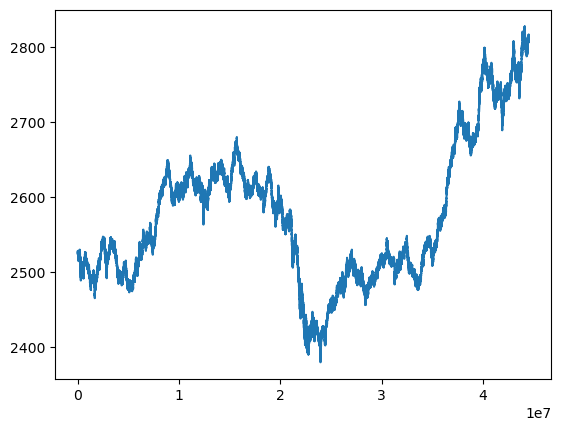

In [6]:
trades_df.price.plot()

In [ ]:
def make_interval_feature_dataset(
    trades: pd.DataFrame,
    dollar_threshold: float,
    feature_window_bars: int = 10,
    horizon_bars: Optional[List[int]] = [5],
    window_mode: str = 'past',  # 'past' 使用过去N个bar的[start,end)，'future' 使用未来N个bar（注意可能泄露）
    add_lags: int = 0,
    rolling_windows: Optional[List[int]] = None,
    rolling_stats: Optional[List[str]] = None,
    bar_zip_path :str = None
) -> Tuple[pd.DataFrame, pd.Series, pd.DataFrame]:
    """
    标签：由 dollar bars 生成的未来 N-bar 对数收益。
    因子：对齐到对应区间 [start_time, end_time)（过去或未来N个bar）上基于逐笔成交直接计算。
    返回：X_interval, y, bars
    """

    bars = None
    if bar_zip_path is not None and os.path.exists(bar_zip_path):
        bars = pd.read_csv(bar_zip_path)
    else:
        bars = build_dollar_bars(trades, dollar_threshold=dollar_threshold)
        os.makedirs(os.path.dirname(bar_zip_path), exist_ok=True)
        bars.to_csv(bar_zip_path, index=False,compression={'method': 'zip', 'archive_name': 'bars.csv'})


    if bars.empty:
        return pd.DataFrame(), pd.Series(dtype=float), bars

    bars = bars.reset_index(drop=True)
    bars['bar_id'] = bars.index
    bars['start_time'] = pd.to_datetime(bars['start_time'])
    bars['end_time'] = pd.to_datetime(bars['end_time'])
    close_s = bars.set_index('bar_id')['close']
    

    # 未来 N-bar 对数收益
    end_time_s = bars.set_index('bar_id')['end_time']
    y = pd.DataFrame(index=close_s.index)

    for horizon in horizon_bars: 
        y_series_log_return = np.log(close_s.shift(-horizon) / close_s)
        tH_time = end_time_s.shift(-horizon)
        y[f'log_return_{horizon}'] = y_series_log_return
        y[f't0_time_{horizon}'] = end_time_s  # 起始时间（同一时间点对不同持有期相同）
        y[f'tH_time_{horizon}'] = tH_time
        
    
    # 预构建高性能上下文（一次即可）
    ctx = _build_trades_context(trades)

    # 计算每个样本的区间
    features = []
    idx = 1
    for bar_id in close_s.index:
        if window_mode == 'past':
            start_idx = bar_id - feature_window_bars
            end_idx = bar_id - 1
            if start_idx < 0:
                features.append({'bar_id': bar_id, '_skip': True})
                continue
        else:  # future 区间（注意信息泄露，仅在需要时使用）
            start_idx = bar_id
            end_idx = bar_id + feature_window_bars - 1
            if end_idx >= len(bars):
                features.append({'bar_id': bar_id, '_skip': True})
                continue
                
        feature_start_ts = bars.loc[start_idx, 'start_time']
        feature_end_ts = bars.loc[end_idx, 'end_time']
        feat = _compute_interval_trade_features_fast(ctx, feature_start_ts, feature_end_ts)
        print(idx)
        idx = idx + 1
        feat['bar_id'] = bar_id
        feat['feature_start'] = feature_start_ts  # 特征计算区间的开始
        feat['feature_end'] = feature_end_ts      # 特征计算区间的结束
        feat['prediction_time'] = bars.loc[bar_id, 'end_time']  # 预测时间点
        for horizon in horizon_bars:
            if bar_id + horizon < len(bars) :
                feat[f'settle_time_{horizon}'] = bars.loc[bar_id + horizon, 'end_time']
            else:
                feat[f'settle_time_{horizon}'] = np.nan
        features.append(feat)

    X = pd.DataFrame(features).set_index('bar_id')
    if '_skip' in X.columns:
        keep_idx = X['_skip'] != True
        X = X.loc[keep_idx].drop(columns=['_skip'])
    
    # 对齐标签
    y = y.loc[X.index]

    # 可选：对区间因子再做滞后/滚动（通常不需要，默认不加）
    if add_lags or rolling_windows:
        X = _add_bar_lags_and_rollings(
            X,
            add_lags=add_lags,
            rolling_windows=rolling_windows,
            rolling_stats=rolling_stats,
        ).dropna()
        y = y.loc[X.index]

    return X, y, bars

def run_bar_interval_pipeline_v2(
    trades: pd.DataFrame,
    dollar_threshold: float,
    feature_window_bars: int = 10,
    horizon_bars: Optional[List[int]] = [5],
    window_mode: str = 'past',
    n_splits: int = 5,
    embargo_bars: Optional[int] = None,
    model_type: str = 'ridge',
    random_state: int = 42,
    bar_zip_path = bar_zip_path
):
    """
    按 N 个 dollar bar 定义的时间区间计算因子，标签为未来 N-bar 对数收益；
    使用区间的真实 end_time 作为索引做 Purged K-Fold，embargo 由 bar 中位时长换算。
    """
    X, y, bars = make_interval_feature_dataset(
        trades=trades,
        dollar_threshold=dollar_threshold,
        feature_window_bars=feature_window_bars,
        horizon_bars=horizon_bars,
        window_mode=window_mode,
        bar_zip_path = bar_zip_path
    )
    
    mask = y[f'log_return_{horizon_bars[-1]}'].notna() & np.isfinite(y[f'log_return_{horizon_bars[-1]}'].values)
    X = X.loc[mask].replace([np.inf, -np.inf], np.nan)
    y = y.loc[X.index]
    # bars = bars[bars['end_time'].isin(X['feature_end'])]

    if X.empty or y.empty:
        print('数据不足或阈值设置过大，无法构造区间数据集 X {} y {} bar{}'.format(len(X), len(y), len(bars)))

    X2 = X.copy()
    y2 = y.copy()
 
    return X2, y2, bars

horizon_bars = [5, 6, 7, 8, 9, 10, 11, 12]

In [37]:
# bar_zip_path = f'/Users/aming/project/python/crypto-trade/output/bars-{start_date}-{end_date}-{dollar_threshold_str}.zip'

X2, y2, bars = run_bar_interval_pipeline_v2(
    trades=trades_df,
    dollar_threshold=10000 * 6000,
    feature_window_bars=30,
    horizon_bars = horizon_bars,
    window_mode='past',
    n_splits=5,
    embargo_bars=None,
    model_type='ridge',
    bar_zip_path=bar_zip_path
)

# print(res.get('eval', {}).get('summary'))

1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
277


<Axes: >

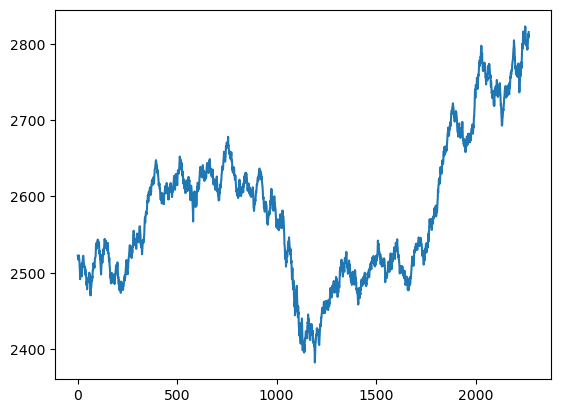

In [21]:
bars.close.plot()

In [33]:
X2.tail(100)

,large_tail_dollar_share,large_tail_trade_share,large_tail_dollar_mean,feature_start,feature_end,prediction_time,settle_time_5,settle_time_6,settle_time_7,settle_time_8,settle_time_9,settle_time_10,settle_time_11,settle_time_12
bar_id,,,,,,,,,,,,,,
2156,0.771706,0.100002,30667.738727,2025-06-10 15:29:42.760,2025-06-10 16:30:39.097,2025-06-10 16:36:27.092,2025-06-10 17:08:58.242,2025-06-10 17:15:23.017,2025-06-10 17:17:15.003,2025-06-10 17:26:08.702,2025-06-10 17:29:16.219,2025-06-10 17:35:42.553,2025-06-10 17:45:09.330,2025-06-10 17:57:33.377
2157,0.773888,0.100002,30219.059691,2025-06-10 15:30:32.403,2025-06-10 16:36:27.092,2025-06-10 16:40:24.777,2025-06-10 17:15:23.017,2025-06-10 17:17:15.003,2025-06-10 17:26:08.702,2025-06-10 17:29:16.219,2025-06-10 17:35:42.553,2025-06-10 17:45:09.330,2025-06-10 17:57:33.377,2025-06-10 18:03:45.337
2158,0.774380,0.100000,29789.599375,2025-06-10 15:31:17.181,2025-06-10 16:40:24.777,2025-06-10 16:48:57.230,2025-06-10 17:17:15.003,2025-06-10 17:26:08.702,2025-06-10 17:29:16.219,2025-06-10 17:35:42.553,2025-06-10 17:45:09.330,2025-06-10 17:57:33.377,2025-06-10 18:03:45.337,2025-06-10 18:15:46.550
2159,0.776840,0.100002,29127.147733,2025-06-10 15:32:17.349,2025-06-10 16:48:57.230,2025-06-10 16:57:50.604,2025-06-10 17:26:08.702,2025-06-10 17:29:16.219,2025-06-10 17:35:42.553,2025-06-10 17:45:09.330,2025-06-10 17:57:33.377,2025-06-10 18:03:45.337,2025-06-10 18:15:46.550,2025-06-10 18:27:08.033
2160,0.778482,0.100002,28706.598876,2025-06-10 15:32:42.777,2025-06-10 16:57:50.604,2025-06-10 17:00:55.552,2025-06-10 17:29:16.219,2025-06-10 17:35:42.553,2025-06-10 17:45:09.330,2025-06-10 17:57:33.377,2025-06-10 18:03:45.337,2025-06-10 18:15:46.550,2025-06-10 18:27:08.033,2025-06-10 18:32:12.292
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2251,0.788822,0.100000,26750.003129,2025-06-10 21:15:34.202,2025-06-10 22:31:58.977,2025-06-10 22:34:53.671,2025-06-10 22:55:07.919,2025-06-10 23:00:11.474,2025-06-10 23:06:06.823,2025-06-10 23:09:28.495,2025-06-10 23:15:35.629,2025-06-10 23:21:43.103,2025-06-10 23:30:39.711,2025-06-10 23:37:57.500
2252,0.789273,0.100001,26129.588927,2025-06-10 21:16:14.122,2025-06-10 22:34:53.671,2025-06-10 22:38:44.332,2025-06-10 23:00:11.474,2025-06-10 23:06:06.823,2025-06-10 23:09:28.495,2025-06-10 23:15:35.629,2025-06-10 23:21:43.103,2025-06-10 23:30:39.711,2025-06-10 23:37:57.500,2025-06-10 23:41:54.488
2253,0.788081,0.100001,26123.796606,2025-06-10 21:19:07.125,2025-06-10 22:38:44.332,2025-06-10 22:42:09.674,2025-06-10 23:06:06.823,2025-06-10 23:09:28.495,2025-06-10 23:15:35.629,2025-06-10 23:21:43.103,2025-06-10 23:30:39.711,2025-06-10 23:37:57.500,2025-06-10 23:41:54.488,2025-06-10 23:45:38.016


In [32]:
y2

,log_return_5,t0_time_5,tH_time_5,log_return_6,t0_time_6,tH_time_6,log_return_7,t0_time_7,tH_time_7,log_return_8,...,tH_time_9,log_return_10,t0_time_10,tH_time_10,log_return_11,t0_time_11,tH_time_11,log_return_12,t0_time_12,tH_time_12
bar_id,,,,,,,,,,,,,,,,,,,,,
30,-0.003419,2025-06-01 06:03:58.609,2025-06-01 08:00:36.903,-0.005483,2025-06-01 06:03:58.609,2025-06-01 08:13:40.235,-0.007299,2025-06-01 06:03:58.609,2025-06-01 08:26:02.223,-0.004489,...,2025-06-01 08:56:46.386,-0.008028,2025-06-01 06:03:58.609,2025-06-01 09:09:12.513,-0.007715,2025-06-01 06:03:58.609,2025-06-01 09:17:45.679,-0.008605,2025-06-01 06:03:58.609,2025-06-01 09:22:57.244
31,-0.002941,2025-06-01 06:21:52.622,2025-06-01 08:13:40.235,-0.004756,2025-06-01 06:21:52.622,2025-06-01 08:26:02.223,-0.001946,2025-06-01 06:21:52.622,2025-06-01 08:38:34.552,-0.003292,...,2025-06-01 09:09:12.513,-0.005173,2025-06-01 06:21:52.622,2025-06-01 09:17:45.679,-0.006062,2025-06-01 06:21:52.622,2025-06-01 09:22:57.244,-0.007141,2025-06-01 06:21:52.622,2025-06-01 09:30:36.701
32,-0.005155,2025-06-01 06:47:45.803,2025-06-01 08:26:02.223,-0.002344,2025-06-01 06:47:45.803,2025-06-01 08:38:34.552,-0.003691,2025-06-01 06:47:45.803,2025-06-01 08:56:46.386,-0.005883,...,2025-06-01 09:17:45.679,-0.006460,2025-06-01 06:47:45.803,2025-06-01 09:22:57.244,-0.007539,2025-06-01 06:47:45.803,2025-06-01 09:30:36.701,-0.010883,2025-06-01 06:47:45.803,2025-06-01 09:31:17.384
33,-0.001627,2025-06-01 07:11:23.292,2025-06-01 08:38:34.552,-0.002973,2025-06-01 07:11:23.292,2025-06-01 08:56:46.386,-0.005166,2025-06-01 07:11:23.292,2025-06-01 09:09:12.513,-0.004854,...,2025-06-01 09:22:57.244,-0.006822,2025-06-01 07:11:23.292,2025-06-01 09:30:36.701,-0.010166,2025-06-01 07:11:23.292,2025-06-01 09:31:17.384,-0.008304,2025-06-01 07:11:23.292,2025-06-01 09:33:39.068
34,-0.002084,2025-06-01 07:37:18.117,2025-06-01 08:56:46.386,-0.004277,2025-06-01 07:37:18.117,2025-06-01 09:09:12.513,-0.003965,2025-06-01 07:37:18.117,2025-06-01 09:17:45.679,-0.004854,...,2025-06-01 09:30:36.701,-0.009277,2025-06-01 07:37:18.117,2025-06-01 09:31:17.384,-0.007415,2025-06-01 07:37:18.117,2025-06-01 09:33:39.068,-0.009076,2025-06-01 07:37:18.117,2025-06-01 09:41:07.404
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2251,-0.005766,2025-06-10 22:34:53.671,2025-06-10 22:55:07.919,-0.004860,2025-06-10 22:34:53.671,2025-06-10 23:00:11.474,-0.005652,2025-06-10 22:34:53.671,2025-06-10 23:06:06.823,-0.008859,...,2025-06-10 23:15:35.629,-0.008737,2025-06-10 22:34:53.671,2025-06-10 23:21:43.103,-0.006663,2025-06-10 22:34:53.671,2025-06-10 23:30:39.711,-0.005798,2025-06-10 22:34:53.671,2025-06-10 23:37:57.500
2252,-0.002557,2025-06-10 22:38:44.332,2025-06-10 23:00:11.474,-0.003349,2025-06-10 22:38:44.332,2025-06-10 23:06:06.823,-0.006556,2025-06-10 22:38:44.332,2025-06-10 23:09:28.495,-0.005751,...,2025-06-10 23:21:43.103,-0.004360,2025-06-10 22:38:44.332,2025-06-10 23:30:39.711,-0.003496,2025-06-10 22:38:44.332,2025-06-10 23:37:57.500,-0.001029,2025-06-10 22:38:44.332,2025-06-10 23:41:54.488
2253,-0.000671,2025-06-10 22:42:09.674,2025-06-10 23:06:06.823,-0.003878,2025-06-10 22:42:09.674,2025-06-10 23:09:28.495,-0.003072,2025-06-10 22:42:09.674,2025-06-10 23:15:35.629,-0.003756,...,2025-06-10 23:30:39.711,-0.000817,2025-06-10 22:42:09.674,2025-06-10 23:37:57.500,0.001650,2025-06-10 22:42:09.674,2025-06-10 23:41:54.488,0.003372,2025-06-10 22:42:09.674,2025-06-10 23:45:38.016


In [34]:
bars

,start_time,end_time,open,high,low,close,volume,dollar_value,buy_volume,sell_volume,trades,bar_id
0,2025-06-01 00:00:04.779,2025-06-01 00:12:14.256,2527.08,2527.98,2522.22,2522.22,23773.670,6.002827e+07,11291.717,12481.953,28970,0
1,2025-06-01 00:12:14.263,2025-06-01 00:13:22.123,2522.22,2522.82,2517.28,2520.00,23801.685,5.997428e+07,9734.751,14066.934,12984,1
2,2025-06-01 00:13:22.123,2025-06-01 00:17:03.625,2520.00,2520.00,2515.06,2518.04,23829.899,6.000530e+07,8493.814,15336.085,22120,2
3,2025-06-01 00:17:03.625,2025-06-01 00:24:10.931,2518.04,2521.94,2515.80,2518.32,23819.881,5.999221e+07,13123.518,10696.363,21221,3
4,2025-06-01 00:24:10.931,2025-06-01 00:34:00.712,2518.32,2522.20,2514.28,2516.80,23834.505,5.999997e+07,11625.853,12208.652,32039,4
...,...,...,...,...,...,...,...,...,...,...,...,...
2263,2025-06-10 23:30:39.711,2025-06-10 23:37:57.500,2798.89,2803.33,2797.00,2801.31,21434.187,6.003575e+07,12641.169,8793.018,23879,2263
2264,2025-06-10 23:37:57.500,2025-06-10 23:41:54.488,2801.31,2810.09,2800.52,2808.23,21424.017,6.010588e+07,14006.033,7417.984,18691,2264
2265,2025-06-10 23:41:54.488,2025-06-10 23:45:38.016,2808.23,2813.57,2808.00,2813.07,21308.785,5.989107e+07,11295.106,10013.679,18966,2265
2266,2025-06-10 23:45:38.016,2025-06-10 23:52:35.278,2813.07,2814.88,2805.00,2808.35,21352.996,5.997417e+07,9098.513,12254.483,25186,2266


In [12]:
# X2.drop(columns=['interval_start', 'interval_end'], inplace=True)
# y2.drop(columns=['end_time'], inplace=True)
X2
# X2
# y2

,large_tail_dollar_share,large_tail_trade_share,large_tail_dollar_mean,feature_start,feature_end,prediction_time,settle_time
bar_id,,,,,,,
30,0.786192,0.100001,18051.490529,2025-06-01 00:00:04.779,2025-06-01 05:27:05.998,2025-06-01 06:03:58.609,2025-06-01 08:00:36.903
31,0.786108,0.100001,17873.352769,2025-06-01 00:12:14.263,2025-06-01 06:03:58.609,2025-06-01 06:21:52.622,2025-06-01 08:13:40.235
32,0.785148,0.100000,17538.471538,2025-06-01 00:13:22.123,2025-06-01 06:21:52.622,2025-06-01 06:47:45.803,2025-06-01 08:26:02.223
33,0.784590,0.100001,17224.800928,2025-06-01 00:17:03.625,2025-06-01 06:47:45.803,2025-06-01 07:11:23.292,2025-06-01 08:38:34.552
34,0.783652,0.100001,17009.129087,2025-06-01 00:24:10.931,2025-06-01 07:11:23.292,2025-06-01 07:37:18.117,2025-06-01 08:56:46.386
...,...,...,...,...,...,...,...
2258,0.785905,0.100002,25570.471560,2025-06-10 21:37:31.758,2025-06-10 23:00:11.474,2025-06-10 23:06:06.823,2025-06-10 23:37:57.500
2259,0.786739,0.100001,24970.605315,2025-06-10 21:39:42.728,2025-06-10 23:06:06.823,2025-06-10 23:09:28.495,2025-06-10 23:41:54.488
2260,0.787004,0.100000,24403.586701,2025-06-10 21:41:18.065,2025-06-10 23:09:28.495,2025-06-10 23:15:35.629,2025-06-10 23:45:38.016


In [38]:
X2_y_pd = pd.concat([X2, y2], axis=1)

def winsorize_single_factor(series, quantiles=(0.01, 0.99)):
    if len(quantiles) != 2 or quantiles[0] >= quantiles[1]:
        raise ValueError("quantiles必须是(低分位, 高分位)，且低分位 < 高分位")
    
    if quantiles[0] < 0 or quantiles[1] > 1:
        raise ValueError("分位数必须在[0, 1]范围内")
    
    # 定义单组缩尾函数
    lower = series.quantile(quantiles[0])
    upper = series.quantile(quantiles[1])
    return  series.clip(lower=lower, upper=upper)

def rolling_z_score(series, window=30):
    mean_ = ta.MA(series,window)
    std_ = ta.STDDEV(series,window)
    return (series - mean_) / std_



In [36]:
X2_y_pd

,large_tail_dollar_share,large_tail_trade_share,large_tail_dollar_mean,feature_start,feature_end,prediction_time,settle_time_5,settle_time_6,settle_time_7,settle_time_8,...,tH_time_9,log_return_10,t0_time_10,tH_time_10,log_return_11,t0_time_11,tH_time_11,log_return_12,t0_time_12,tH_time_12
bar_id,,,,,,,,,,,,,,,,,,,,,
30,0.786192,0.100001,18051.490529,2025-06-01 00:00:04.779,2025-06-01 05:27:05.998,2025-06-01 06:03:58.609,2025-06-01 08:00:36.903,2025-06-01 08:13:40.235,2025-06-01 08:26:02.223,2025-06-01 08:38:34.552,...,2025-06-01 08:56:46.386,-0.008028,2025-06-01 06:03:58.609,2025-06-01 09:09:12.513,-0.007715,2025-06-01 06:03:58.609,2025-06-01 09:17:45.679,-0.008605,2025-06-01 06:03:58.609,2025-06-01 09:22:57.244
31,0.786108,0.100001,17873.352769,2025-06-01 00:12:14.263,2025-06-01 06:03:58.609,2025-06-01 06:21:52.622,2025-06-01 08:13:40.235,2025-06-01 08:26:02.223,2025-06-01 08:38:34.552,2025-06-01 08:56:46.386,...,2025-06-01 09:09:12.513,-0.005173,2025-06-01 06:21:52.622,2025-06-01 09:17:45.679,-0.006062,2025-06-01 06:21:52.622,2025-06-01 09:22:57.244,-0.007141,2025-06-01 06:21:52.622,2025-06-01 09:30:36.701
32,0.785148,0.100000,17538.471538,2025-06-01 00:13:22.123,2025-06-01 06:21:52.622,2025-06-01 06:47:45.803,2025-06-01 08:26:02.223,2025-06-01 08:38:34.552,2025-06-01 08:56:46.386,2025-06-01 09:09:12.513,...,2025-06-01 09:17:45.679,-0.006460,2025-06-01 06:47:45.803,2025-06-01 09:22:57.244,-0.007539,2025-06-01 06:47:45.803,2025-06-01 09:30:36.701,-0.010883,2025-06-01 06:47:45.803,2025-06-01 09:31:17.384
33,0.784590,0.100001,17224.800928,2025-06-01 00:17:03.625,2025-06-01 06:47:45.803,2025-06-01 07:11:23.292,2025-06-01 08:38:34.552,2025-06-01 08:56:46.386,2025-06-01 09:09:12.513,2025-06-01 09:17:45.679,...,2025-06-01 09:22:57.244,-0.006822,2025-06-01 07:11:23.292,2025-06-01 09:30:36.701,-0.010166,2025-06-01 07:11:23.292,2025-06-01 09:31:17.384,-0.008304,2025-06-01 07:11:23.292,2025-06-01 09:33:39.068
34,0.783652,0.100001,17009.129087,2025-06-01 00:24:10.931,2025-06-01 07:11:23.292,2025-06-01 07:37:18.117,2025-06-01 08:56:46.386,2025-06-01 09:09:12.513,2025-06-01 09:17:45.679,2025-06-01 09:22:57.244,...,2025-06-01 09:30:36.701,-0.009277,2025-06-01 07:37:18.117,2025-06-01 09:31:17.384,-0.007415,2025-06-01 07:37:18.117,2025-06-01 09:33:39.068,-0.009076,2025-06-01 07:37:18.117,2025-06-01 09:41:07.404
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2251,0.788822,0.100000,26750.003129,2025-06-10 21:15:34.202,2025-06-10 22:31:58.977,2025-06-10 22:34:53.671,2025-06-10 22:55:07.919,2025-06-10 23:00:11.474,2025-06-10 23:06:06.823,2025-06-10 23:09:28.495,...,2025-06-10 23:15:35.629,-0.008737,2025-06-10 22:34:53.671,2025-06-10 23:21:43.103,-0.006663,2025-06-10 22:34:53.671,2025-06-10 23:30:39.711,-0.005798,2025-06-10 22:34:53.671,2025-06-10 23:37:57.500
2252,0.789273,0.100001,26129.588927,2025-06-10 21:16:14.122,2025-06-10 22:34:53.671,2025-06-10 22:38:44.332,2025-06-10 23:00:11.474,2025-06-10 23:06:06.823,2025-06-10 23:09:28.495,2025-06-10 23:15:35.629,...,2025-06-10 23:21:43.103,-0.004360,2025-06-10 22:38:44.332,2025-06-10 23:30:39.711,-0.003496,2025-06-10 22:38:44.332,2025-06-10 23:37:57.500,-0.001029,2025-06-10 22:38:44.332,2025-06-10 23:41:54.488
2253,0.788081,0.100001,26123.796606,2025-06-10 21:19:07.125,2025-06-10 22:38:44.332,2025-06-10 22:42:09.674,2025-06-10 23:06:06.823,2025-06-10 23:09:28.495,2025-06-10 23:15:35.629,2025-06-10 23:21:43.103,...,2025-06-10 23:30:39.711,-0.000817,2025-06-10 22:42:09.674,2025-06-10 23:37:57.500,0.001650,2025-06-10 22:42:09.674,2025-06-10 23:41:54.488,0.003372,2025-06-10 22:42:09.674,2025-06-10 23:45:38.016


<Axes: >

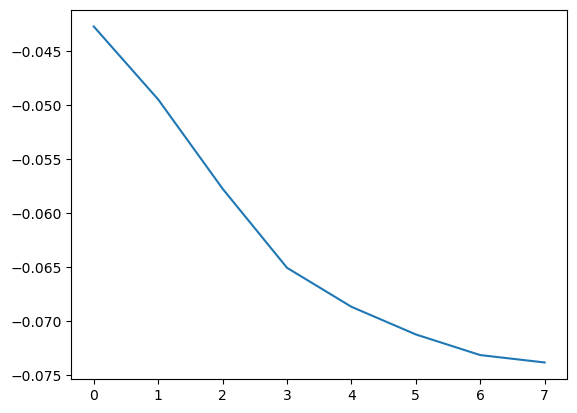

In [ ]:
large_tail_dollar_share_winsorize = winsorize_single_factor(X2_y_pd.large_tail_dollar_share)

large_tail_dollar_share_winsorize_zscore = rolling_z_score(large_tail_dollar_share_winsorize)

# large_tail_dollar_share_winsorize_zscore.hist(bins=100)

corr_list = []
for horizon in horizon_bars:
    corr_list.append(large_tail_dollar_share_winsorize_zscore.corr(X2_y_pd[f'log_return_{horizon}']))

corr_list

pd.Series(corr_list).plot()


# log_return_corr = pd.concat(corr_list)

# print(log_return_corr) 

# log_return_corr.plot()

In [ ]:
# ofi_roll_sum_max_mean = ta.MA(ofi_roll_sum_max,10)
# ofi_roll_sum_max_std = ta.STDDEV(ofi_roll_sum_max,10)
# ofi_roll_sum_max_norm = (ofi_roll_sum_max - ofi_roll_sum_max_mean) / ofi_roll_sum_max_std / 3
# ofi_roll_sum_max_norm.hist(bins=100)

ofi_roll_sum_max = X2_y_pd.ofi_roll_sum_max
q1 = ofi_roll_sum_max.rolling(100).quantile(0.10)
q3 = ofi_roll_sum_max.rolling(100).quantile(0.90)
iqr = q3 - q1
upper_bound = q3 + 1.5 * iqr
lower_bound = q1 - 1.5 * iqr
ofi_roll_sum_max_clipped = ofi_roll_sum_max.clip(lower_bound, upper_bound)
# ofi_roll_sum_max_clipped.hist(bins=100)

ofi_roll_sum_max_clipped_mean = ta.MA(ofi_roll_sum_max_clipped,10)
ofi_roll_sum_max_clipped_std = ta.STDDEV(ofi_roll_sum_max_clipped,10)
ofi_roll_sum_max_clipped_norm = (ofi_roll_sum_max_clipped - ofi_roll_sum_max_clipped_mean) / ofi_roll_sum_max_clipped_std / 3
ofi_roll_sum_max_clipped_norm.hist(bins=100)

ofi_roll_sum_max_clipped_norm.corr(X2_y_pd.close)

In [ ]:
# X2_y_pd.gof_by_count.hist(bins=100)
gof_by_count = X2_y_pd.gof_by_count
# gof_by_count.hist(bins=100)
gof_by_count_max = gof_by_count.quantile(0.95)
gof_by_count_min = gof_by_count.quantile(0.05)
gof_by_count_deal = gof_by_count[(gof_by_count > gof_by_count_min)  & (gof_by_count < gof_by_count_max)]
# gof_by_count_deal
# gof_by_count_deal.hist(bins=100)

gof_by_count_deal_mean = ta.MA(gof_by_count_deal,10)
gof_by_count_deal_std = ta.STDDEV(gof_by_count_deal,10)
gof_by_count_deal_norm = (gof_by_count_deal - gof_by_count_deal_mean) / gof_by_count_deal_std

# amihud_lambda_norm.hist(bins=100)
# amihud_lambda_norm.hist(bins = 100)
# gof_by_count_deal_norm.hist(bins=100)
# gof_by_count_deal_norm.corr(X2_y_pd.close)

normal_window = range(5,30,5)

# for window in normal_window:
#     gof_by_count_deal_mean = ta.MA(gof_by_count_deal,window)
#     gof_by_count_deal_std = ta.STDDEV(gof_by_count_deal,window)
#     gof_by_count_deal_norm = (gof_by_count_deal - gof_by_count_deal_mean) / gof_by_count_deal_std
#     print('window {}, ic {}'.format(window, gof_by_count_deal_norm.corr(X2_y_pd.close)))



In [ ]:
gof_by_count_deal_norm = gof_by_count_deal_norm / 3

In [ ]:
gof_by_count_deal_norm_position = ((gof_by_count_deal_norm>0.5)|(gof_by_count_deal_norm<-0.5)) * gof_by_count_deal_norm

net_value = 1+(gof_by_count_deal_norm_position*X2_y_pd['close'].fillna(0)).cumsum()

In [ ]:
net_value.plot()

In [ ]:
X2_y_pd.ofi_signed_qty_sum.hist(bins=100)
# X2_y_pd.ofi_signed_quote_sum.plot()
# X2_y_pd.ofi_trade_count_diff.plot()
# X2_y_pd.ofi_signed_quote_sum.hist(bins = 100)

In [ ]:
ofi_signed_qty_sum = X2_y_pd.ofi_signed_qty_sum
normal_window = range(3,30,3)

for window in normal_window:
    ofi_signed_qty_sum_mean = ta.MA(ofi_signed_qty_sum,window)
    ofi_signed_qty_sum_std = ta.STDDEV(ofi_signed_qty_sum,window)
    ofi_signed_qty_sum_norm = (ofi_signed_qty_sum - ofi_signed_qty_sum_mean) / ofi_signed_qty_sum_std / 3
    print('window {}, ic {}'.format(window, ofi_signed_qty_sum_norm.corr(X2_y_pd.close)))

ofi_signed_qty_sum_norm.hist(bins=100)
# ofi_trade_count_diff_mean = ta.MA(ofi_trade_count_diff,5)
# ofi_trade_count_diff_std = ta.STDDEV(ofi_trade_count_diff,5)
# ofi_trade_count_diff_norm = (ofi_trade_count_diff - ofi_trade_count_diff_mean) / ofi_trade_count_diff_std
# # ofi_trade_count_diff_norm.plot()
# ofi_trade_count_diff_norm.hist(bins=100)
# ofi_trade_count_diff_norm.corr(X2_y_pd.close)

# X2_y_pd['ofi_trade_count_diff_norm'].corr(X2_y_pd.close)

In [ ]:
ofi_signed_qty_sum_norm.hist(bins=100)

In [ ]:
# ofi_signed_qty_sum_norm_position = ofi_signed_qty_sum_norm
high_freq_downside_ratio_norm_position_binning_position = ((ofi_signed_qty_sum_norm>0.5)|(ofi_signed_qty_sum_norm<-0.5)) * ofi_signed_qty_sum_norm
high_freq_downside_ratio_norm_position_binning_position

In [ ]:

net_value = 1+(high_freq_downside_ratio_norm_position_binning_position*X2_y_pd['close'].fillna(0)).cumsum()

In [ ]:
net_value.plot()